# UK ELECTRICITY MARKET DISPATCH PAY AS CLEAR MERIT ORDER

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_data(path):
    # Load all sheets and ensure time series are sorted by hour
    windplants = pd.read_excel(path, "windplants")
    wind_lf  = pd.read_excel(path, "wind_loadfactors")
    solarplants = pd.read_excel(path, "solarplants")
    solar_lf = pd.read_excel(path, "solar_loadfactors")
    gasplants = pd.read_excel(path, "gasplants")
    gas_prices = pd.read_excel(path, "gas_prices")
    demand = pd.read_excel(path, "demand")

    for df in [wind_lf, solar_lf, gas_prices, demand]:
        df.sort_values("hour", inplace=True)

    return windplants, wind_lf, solarplants, solar_lf, gasplants, gas_prices, demand


def process_renewables(plants, loadfactors, tech):
    # Reshape load factors to long format and merge with plant data
    lf = loadfactors.melt(id_vars="hour", var_name="name", value_name="load_factor")
    df = lf.merge(plants, on="name")

    # Compute hourly available output
    df["available_mw"] = df["capacity"] * df["load_factor"]

    # Zero marginal cost for all renewables
    df["marginal_cost"] = 0.0
    df["tech"] = tech
    return df


def process_gas(gasplants, gas_prices):
    # Combine gas plants with hourly gas prices
    g = gasplants.assign(key=1).merge(gas_prices.assign(key=1), on="key").drop("key", axis=1)

    # Gas units have fixed capacity but varying marginal cost over time
    g["available_mw"] = g["capacity"]
    g["marginal_cost"] = (g["price"] * 34.121) / (100 * g["efficiency"])
    g["tech"] = "Gas"
    return g


def dispatch_hourly(generators, demand):
    # Hourly merit-order dispatch
    records = []

    for h in demand["hour"]:
        need = demand.loc[demand["hour"] == h, "demand"].iat[0]

        # Sort by marginal cost for merit order
        stack = generators[generators["hour"] == h].sort_values("marginal_cost")

        sent = 0
        for _, row in stack.iterrows():
            if sent >= need:
                break

            take = min(row["available_mw"], need - sent)
            sent += take

            records.append({
                "hour": h,
                "name": row["name"],
                "tech": row["tech"],
                "dispatched_mw": take,
                "marginal_cost": row["marginal_cost"]
            })

    return pd.DataFrame(records)


def summarize_hourly(dispatch_df, demand):
    # Aggregate dispatch by hour and technology
    table = dispatch_df.groupby(["hour", "tech"])["dispatched_mw"].sum().unstack(fill_value=0)

    table["dispatched"] = table.sum(axis=1)

    # Add demand and compute system-level indicators
    table = table.merge(demand, on="hour")
    table["shortage"] = table["dispatched"] < table["demand"] - 1e-2
    table["mismatch"] = table["dispatched"] - table["demand"]

    # Hourly marginal price = highest MC unit dispatched
    table["price"] = dispatch_df.groupby("hour")["marginal_cost"].max().values

    # Tech shares
    for t in ["Wind", "Solar", "Gas"]:
        table[t] = table.get(t, 0)
        table[f"{t.lower()}_pct"] = table[t] / table["dispatched"]

    return table.reset_index()


def plot_dispatch(hourly):
    # Dispatch stack
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.stackplot(
        hourly["hour"],
        hourly["Wind"], hourly["Solar"], hourly["Gas"],
        labels=["Wind", "Solar", "Gas"],
        colors=["#1f77b4", "#ff7f0e", "#2ca02c"],
        alpha=0.85
    )

    # Demand line
    ax1.plot(hourly["hour"], hourly["demand"], "--", color="red", lw=1.4)

    # Highlight shortage hours
    for h in hourly[hourly["shortage"]]["hour"]:
        ax1.axvline(h, color="black", ls=":", alpha=0.4)

    ax1.set_xlabel("Hour")
    ax1.set_ylabel("Dispatch (MW)")
    ax1.legend(loc="upper left")

    # Marginal price
    ax2 = ax1.twinx()
    ax2.plot(hourly["hour"], hourly["price"], color="purple", lw=1.5)
    ax2.set_ylabel("Price (£/MWh)")

    plt.tight_layout()
    plt.show()


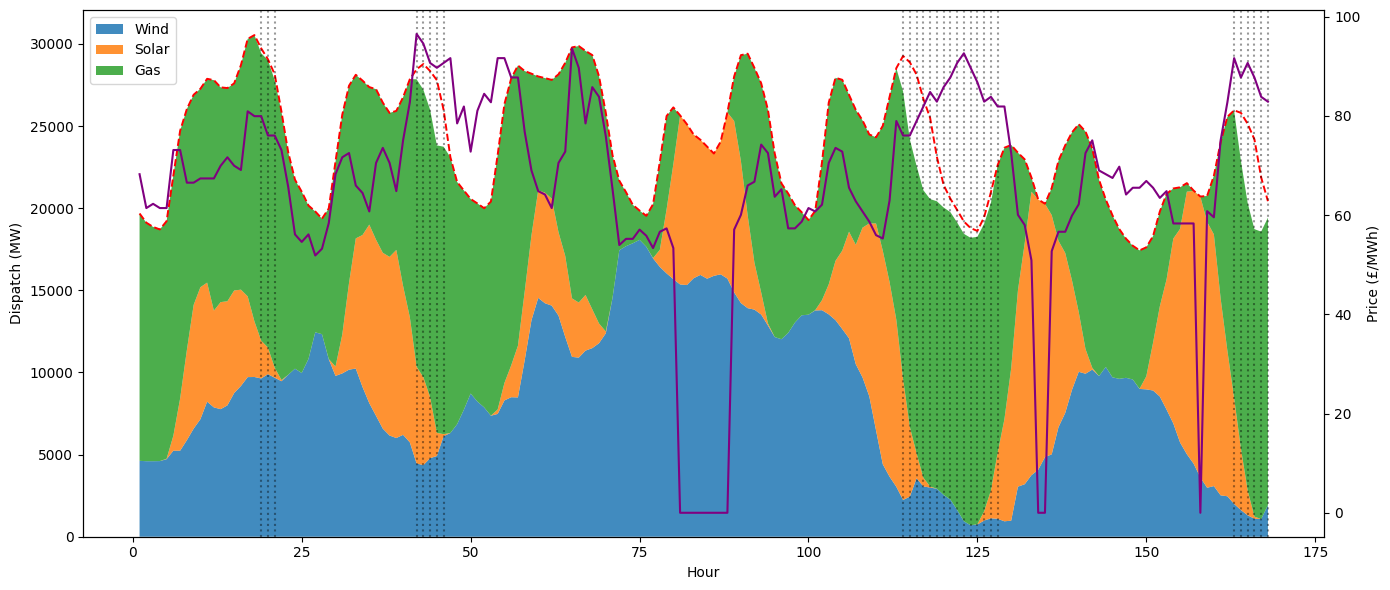

In [12]:
# Main execution
path = "data 2.xlsx"

windplants, wind_lf, solarplants, solar_lf, gasplants, gas_prices, demand = load_data(path)

wind  = process_renewables(windplants, wind_lf, "Wind")
solar = process_renewables(solarplants, solar_lf, "Solar")
gas   = process_gas(gasplants, gas_prices)

generators = pd.concat([wind, solar, gas], ignore_index=True)

dispatch = dispatch_hourly(generators, demand)
hourly   = summarize_hourly(dispatch, demand)


# results saved in the follow csv
dispatch.to_csv("dispatch_results.csv", index=False)
hourly.to_csv("dispatch_hourly_summary.csv", index=False)

hourly.head()
plot_dispatch(hourly)


Above plot shows the shoratage (indicated by the gap in the demand line) and oversupply of renewables ( with 0 marginal price) correctly


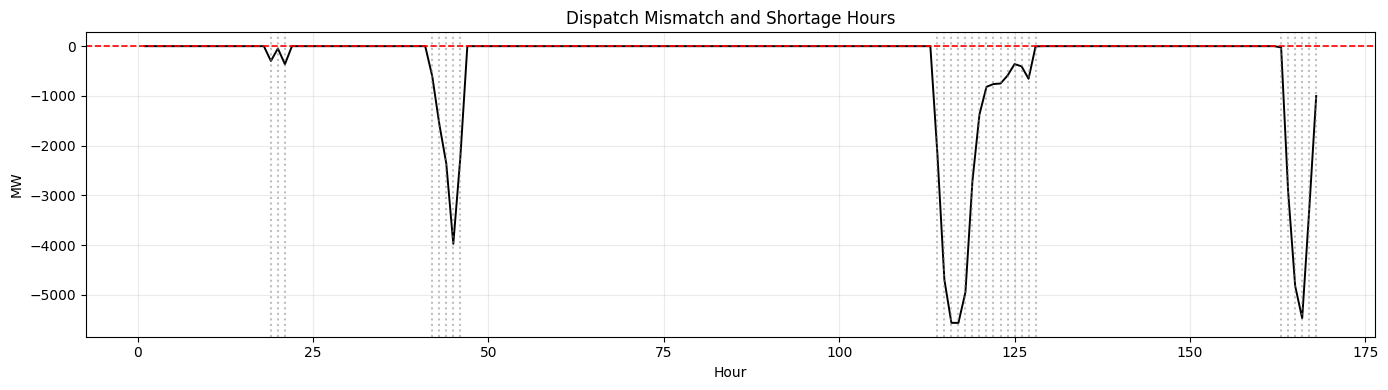

In [13]:
plt.figure(figsize=(14, 4))

plt.plot(
    hourly["hour"],
    hourly["mismatch"],
    color="black",
    linewidth=1.4,
    label="Mismatch (Dispatched - Demand)"
)

plt.axhline(0, color="red", linestyle="--", linewidth=1.2)

short = hourly[hourly["shortage"]]["hour"]
for h in short:
    plt.axvline(h, color="grey", linestyle=":", alpha=0.5)

plt.xlabel("Hour")
plt.ylabel("MW")
plt.title("Dispatch Mismatch and Shortage Hours")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


Above plot shows the shortage hours in electricity dispatched

# MERIT ORDER + PRO RATA WHEN RENEWABLES OVERSUPPLY

We apply pro-rata allocation only when total renewable availability exceeds demand to ensure fair curtailment across wind and solar units with identical marginal costs

In [14]:
def apply_prorata(dispatch, generators, demand):
    records = []

    for h in demand["hour"]:
        needed = demand.loc[demand["hour"] == h, "demand"].iloc[0]

        stack = generators[generators["hour"] == h]
        re_stack = stack[stack["marginal_cost"] == 0].copy()
        gas_stack = stack[stack["marginal_cost"] > 0].copy()

        total_re_avail = re_stack["available_mw"].sum()

        if total_re_avail >= needed:
            # Pro-rata split among renewables
            for _, row in re_stack.iterrows():
                share = row["available_mw"] / total_re_avail
                records.append({
                    "hour": h,
                    "name": row["name"],
                    "tech": row["tech"],
                    "dispatched_mw": needed * share,
                    "marginal_cost": 0.0
                })
        else:
            # Use all renewables
            for _, row in re_stack.iterrows():
                records.append({
                    "hour": h,
                    "name": row["name"],
                    "tech": row["tech"],
                    "dispatched_mw": row["available_mw"],
                    "marginal_cost": 0.0
                })

            remaining = needed - total_re_avail
            gas_stack = gas_stack.sort_values("marginal_cost")
            for _, row in gas_stack.iterrows():
                if remaining <= 0:
                    break
                take = min(row["available_mw"], remaining)
                remaining -= take
                records.append({
                    "hour": h,
                    "name": row["name"],
                    "tech": row["tech"],
                    "dispatched_mw": take,
                    "marginal_cost": row["marginal_cost"]
                })

    return pd.DataFrame(records)


In [15]:
dispatch_prorata = apply_prorata(dispatch, generators, demand)
hourly_prorata = summarize_hourly(dispatch_prorata, demand)

dispatch_prorata.to_csv("dispatch_prorata.csv", index=False)
hourly_prorata.to_csv("hourly_prorata.csv", index=False)

In [16]:

print("\n PRO-RATA RENEWABLE DISPATCH RESULTS ")
print(f"Max mismatch: {hourly_prorata['mismatch'].abs().max():.4f}")
print(f"Shortage hours: {hourly_prorata['shortage'].sum()}")
hourly_prorata.head()



 PRO-RATA RENEWABLE DISPATCH RESULTS 
Max mismatch: 5561.5464
Shortage hours: 29


,index,hour,Gas,Solar,Wind,dispatched,demand,shortage,mismatch,price,wind_pct,solar_pct,gas_pct
0,0,1,15057.363312,0.000000,4620.636688,19678.0,19678.0,False,0.0,68.242000,0.234812,0.0000,0.765188
1,1,2,14522.328629,0.000000,4597.671371,19120.0,19120.0,False,0.0,61.417800,0.240464,0.0000,0.759536
2,2,3,14262.910325,0.000000,4598.589675,18861.5,18861.5,False,0.0,62.270825,0.243808,0.0000,0.756192
3,3,4,14104.117267,0.000000,4603.882733,18708.0,18708.0,False,0.0,61.417800,0.246092,0.0000,0.753908
4,4,5,14464.227781,24.978649,4721.793570,19211.0,19211.0,False,0.0,61.417800,0.245786,0.0013,0.752914


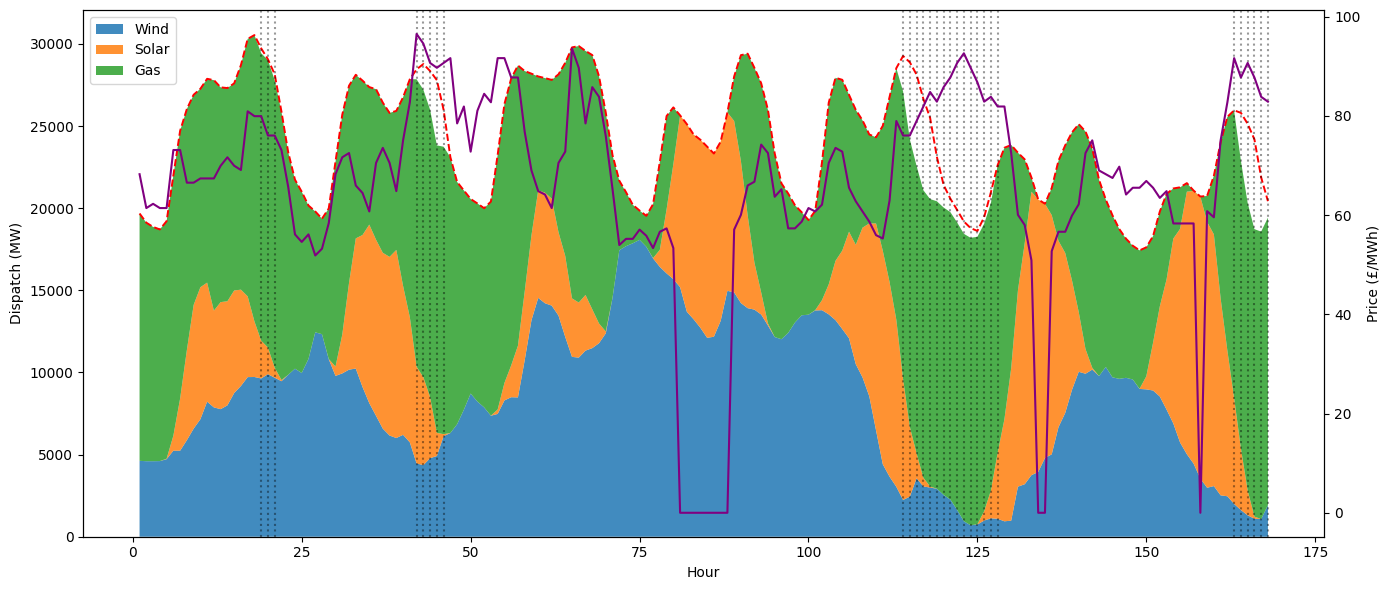

In [17]:
plot_dispatch(hourly_prorata)

# Comparison of wind and solar units in above two methods

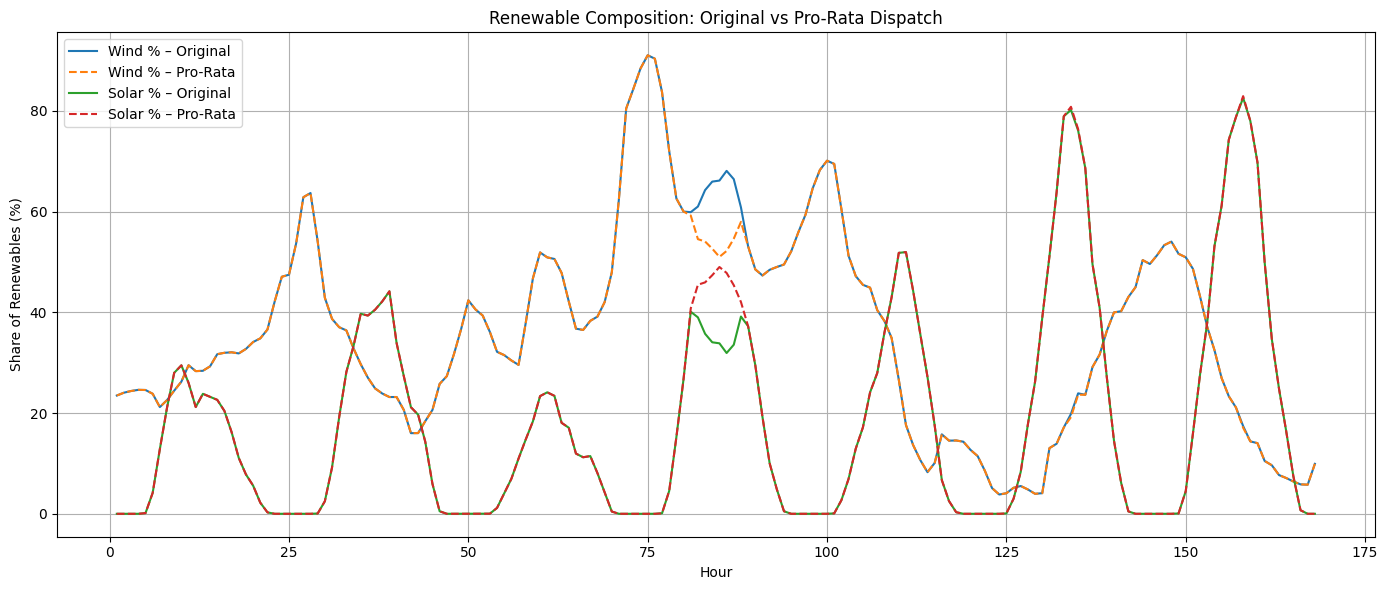

In [18]:
plt.figure(figsize=(14,6))

# Wind %
plt.plot(hourly['hour'], hourly['wind_pct']*100, label='Wind % – Original', linewidth=1.5)

plt.plot(hourly_prorata['hour'], hourly_prorata['wind_pct']*100, label='Wind % – Pro-Rata', linewidth=1.5, linestyle='--')

# Solar %
plt.plot(hourly['hour'], hourly['solar_pct']*100, label='Solar % – Original', linewidth=1.5)

plt.plot(hourly_prorata['hour'], hourly_prorata['solar_pct']*100, label='Solar % – Pro-Rata', linewidth=1.5, linestyle='--')

plt.xlabel("Hour")
plt.ylabel("Share of Renewables (%)")
plt.title("Renewable Composition: Original vs Pro-Rata Dispatch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
